## Import useful libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from PIL import Image
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.ensemble import RandomForestClassifier

## Read the curated dataset

In [2]:
df=pd.read_csv("telco_churn.csv")
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108.15,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151.65,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


## Splitting the dataset into X & y


In [3]:
X=df.drop('Churn',axis=1)
y=df['Churn']

## Train-test split

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=123)

## Decision Tree Classifier

1).**original df**

In [6]:
# Initialize and fit the classifier
clf = DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")
clf.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = clf.predict(X_test)


In [7]:
clf.score(X_test,y_test)

0.7539044013251301

As you can see that the accuracy is high, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.

In [8]:
print(classification_report(y_test, y_pred, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1523
           1       0.57      0.46      0.51       590

    accuracy                           0.75      2113
   macro avg       0.69      0.67      0.67      2113
weighted avg       0.74      0.75      0.75      2113



#here we see that precision, recall, f1-score are around 0.5 for customers who churned. It is because our target variable is imbalanced (as we explored in EDA) so we'll again build model after treating data using SMOTEENN (Upsampling +ENN)

In [9]:
from sklearn.inspection import permutation_importance


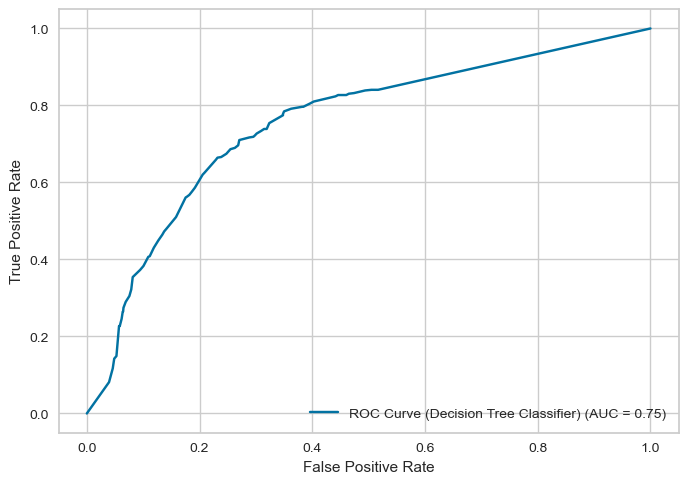

In [11]:
# Predict the class probabilities on the test set
y_prob = clf.predict_proba(X_test)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob[:,1])

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, label="ROC Curve (Decision Tree Classifier) (AUC = %0.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('ROC curve DT.pdf')
plt.show()



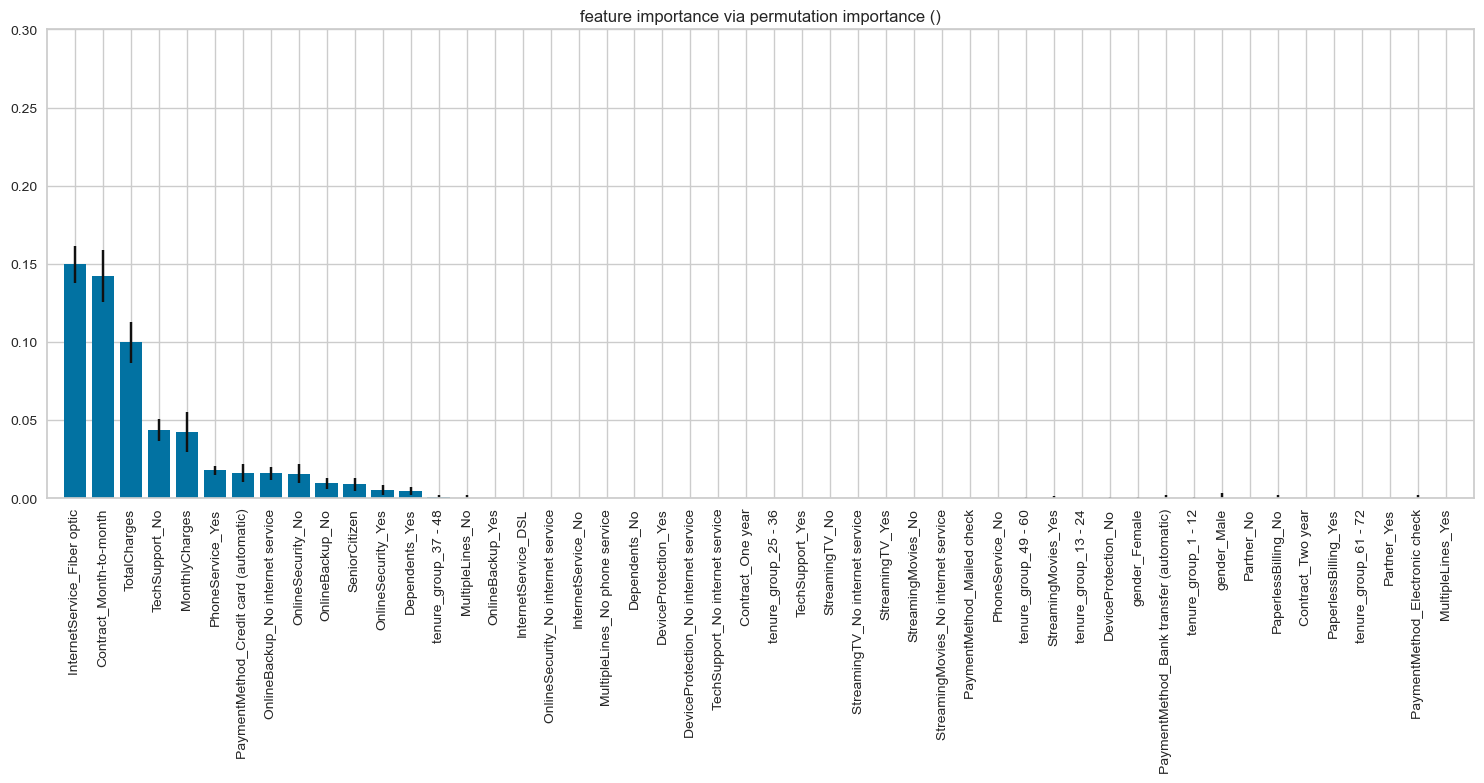

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=clf,
    X=X_test,
    y=y_test,
    scoring='recall',
    n_repeats=50,
    random_state=0
)

indices = np.argsort(result['importances_mean'])[::-1]

plt.figure(figsize=(15, 8))
plt.title("feature importance via permutation importance ()")
plt.bar(
    range(X_test.shape[1]),
    result['importances_mean'][indices],
    yerr=result['importances_std'][indices]
)

plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.ylim([0, 0.3])

plt.tight_layout()
plt.savefig('Feature Importances DT.pdf')
plt.show()

Permutation feature importance is more robust and more credible than built-in feature importance from the model because it measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the realtionship between the feature and the true outcome

2). **df curated by SMOTEEN (Upsampling + ENN)**

In [13]:
sm = SMOTEENN()

X_resampled, y_resampled = sm.fit_resample(X,y)

Xs_train,Xs_test,ys_train,ys_test=train_test_split(X_resampled, y_resampled,test_size=0.3, random_state=123)

clf_dt_smote=DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")
clf_dt_smote.fit(Xs_train,ys_train)
ys_predict = clf_dt_smote.predict(Xs_test)
model_score_smote = clf_dt_smote.score(Xs_test, ys_test)
print(model_score_smote)


0.930648769574944


In [14]:
print(metrics.classification_report(ys_test, ys_predict))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       805
           1       0.94      0.94      0.94       983

    accuracy                           0.93      1788
   macro avg       0.93      0.93      0.93      1788
weighted avg       0.93      0.93      0.93      1788



Now we can see quite better results, i.e.accuracy, precision, recall, f1-score for minority class, i.e., churned customers.
Let's try Random Forest Classifier

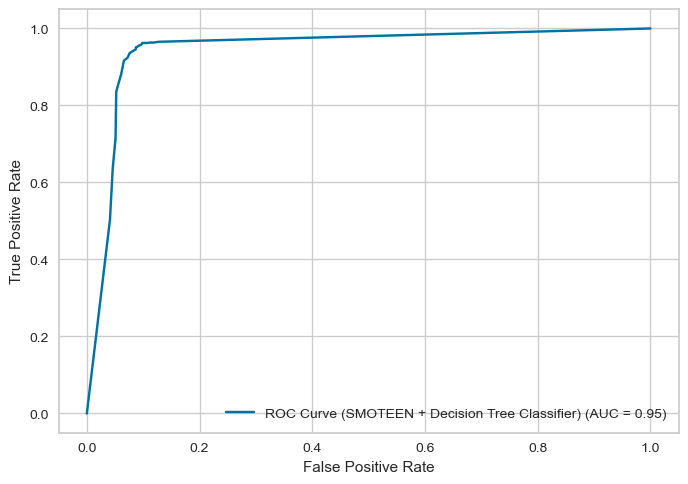

In [28]:
# Predict the class probabilities on the test set
ys_prob = clf_dt_smote.predict_proba(Xs_test)

# Compute the ROC AUC score
roc_auc_smote = roc_auc_score(ys_test, ys_prob[:,1])

# Plot the ROC curve
fpr, tpr, _ = roc_curve(ys_test, ys_prob[:,1])
plt.plot(fpr, tpr, label="ROC Curve (SMOTEEN + Decision Tree Classifier) (AUC = %0.2f)" % roc_auc_smote)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('ROC Curve DT + SMOTEEN.pdf')
plt.show()


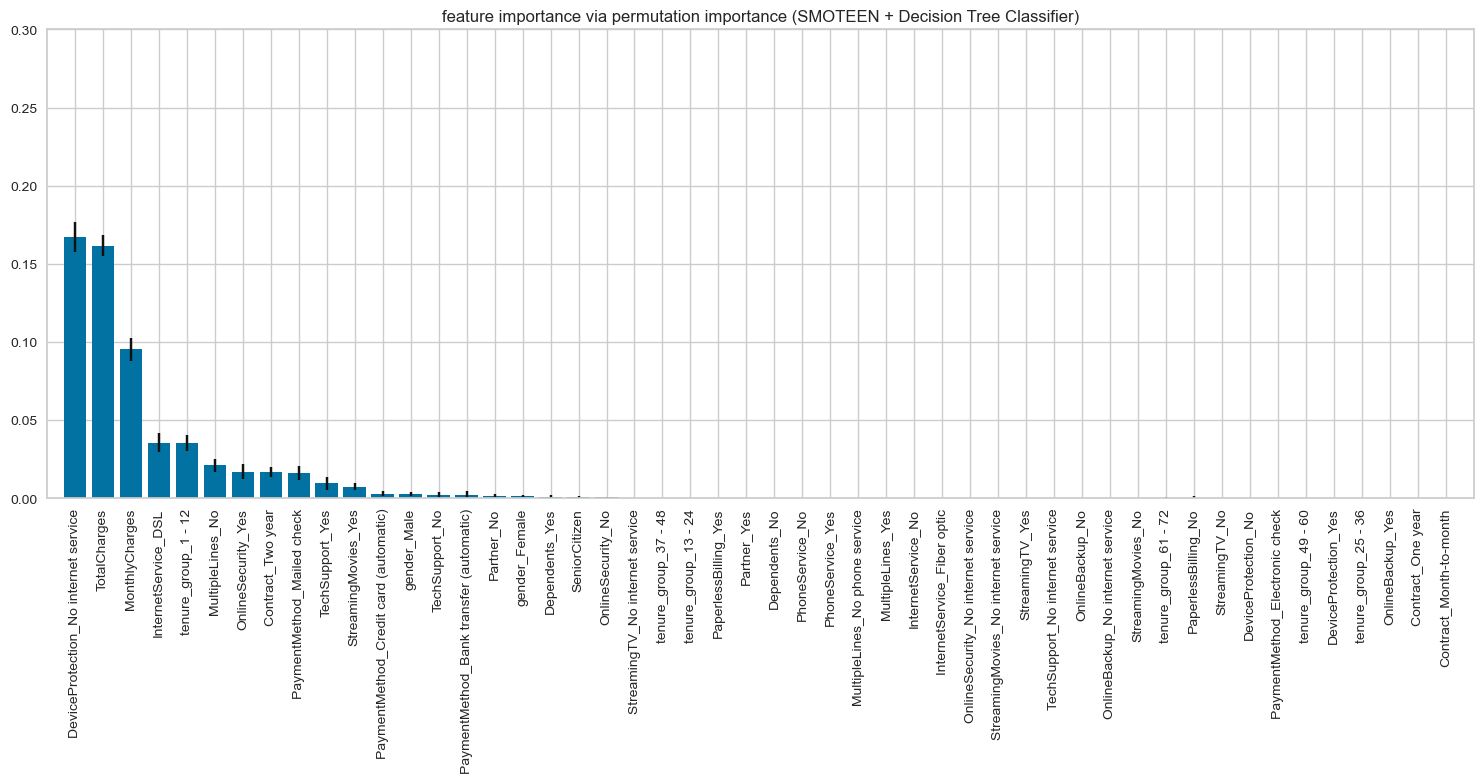

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=clf_dt_smote,
    X=Xs_test,
    y=ys_test,
    scoring='recall',
    n_repeats=50,
    random_state=0
)

indices = np.argsort(result['importances_mean'])[::-1]

plt.figure(figsize=(15, 8))
plt.title("feature importance via permutation importance (SMOTEEN + Decision Tree Classifier)")
plt.bar(
    range(Xs_test.shape[1]),
    result['importances_mean'][indices],
    yerr=result['importances_std'][indices]
)

plt.xticks(range(Xs_test.shape[1]), Xs_test.columns[indices], rotation=90)
plt.xlim([-1, Xs_test.shape[1]])
plt.ylim([0, 0.3])

plt.tight_layout()
plt.savefig('Feature Importance SMOTEEN + Decision Tree Classifier .pdf')
plt.show()

## Random Forest Classifier 

3).**original df**

In [17]:
# Initialize and fit the classifier
clf_rf=RandomForestClassifier(n_estimators=100, max_depth = 9, random_state = 123, criterion = "gini")
clf_rf.fit(X_train, y_train)

# Predict the target values for the test data
y_pred_rf = clf_rf.predict(X_test)


In [18]:
clf_rf.score(X_test,y_test)

0.7893989588263133

In [19]:
print(classification_report(y_test, y_pred_rf, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1523
           1       0.67      0.48      0.56       590

    accuracy                           0.79      2113
   macro avg       0.75      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



Here we see, we still have low precision, recall & f1-score value for churned class. so we will use SMOTEEN for balancing minority class in the dataset and then apply random forest classifier to see if we get increased accuracy & other metrics.

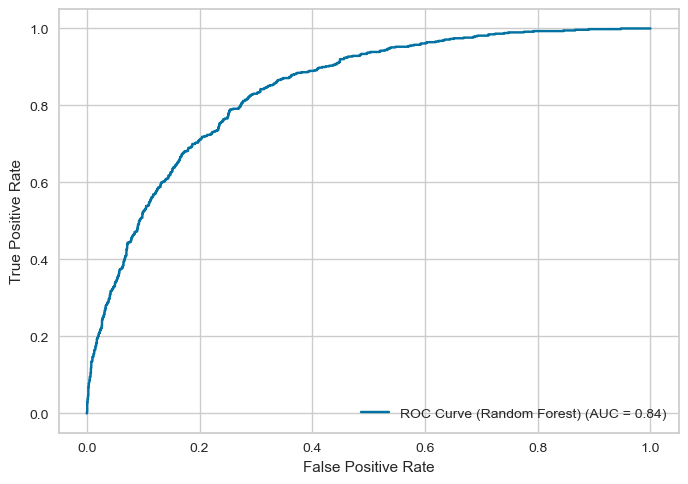

In [27]:
# Predict the class probabilities on the test set
yrf_prob = clf_rf.predict_proba(X_test)

# Compute the ROC AUC score
roc_auc_rf = roc_auc_score(y_test, yrf_prob[:,1])

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, yrf_prob[:,1])
plt.plot(fpr, tpr, label="ROC Curve (Random Forest) (AUC = %0.2f)" % roc_auc_rf)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('ROC Curve RF.pdf')

plt.show()


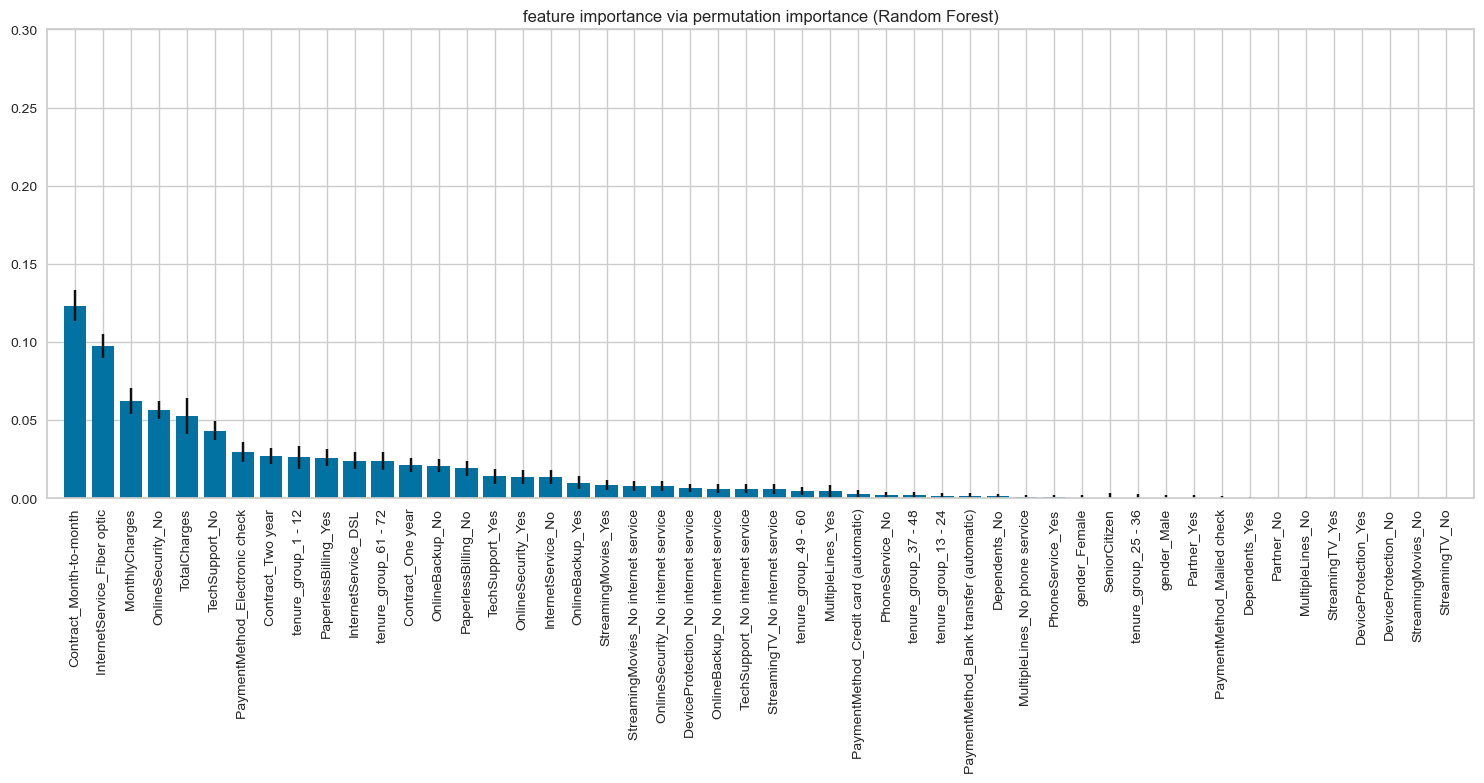

In [29]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=clf_rf,
    X=X_test,
    y=y_test,
    scoring='recall',
    n_repeats=50,
    random_state=0
)

indices = np.argsort(result['importances_mean'])[::-1]

plt.figure(figsize=(15, 8))
plt.title("feature importance via permutation importance (Random Forest)")
plt.bar(
    range(Xs_test.shape[1]),
    result['importances_mean'][indices],
    yerr=result['importances_std'][indices]
)

plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.ylim([0, 0.3])

plt.tight_layout()
plt.savefig('Feature Importance RF.pdf')
plt.show()

4). **df curated by SMOTEEN (Upsampling + ENN)**

In [22]:
sm = SMOTEENN()

X_resampled_rf, y_resampled_rf = sm.fit_resample(X,y)

Xs_train_rf,Xs_test_rf,ys_train_rf,ys_test_rf=train_test_split(X_resampled_rf, y_resampled_rf,test_size=0.3, random_state=123)

clf_rfs_smote=RandomForestClassifier(n_estimators=100, max_depth = 9, random_state = 123, criterion = "gini")
clf_rfs_smote.fit(Xs_train_rf,ys_train_rf)
ys_predict_rf = clf_rfs_smote.predict(Xs_test_rf)
model_score_rf = clf_rfs_smote.score(Xs_test_rf, ys_test_rf)
print(model_score_rf)


0.9549343981745579


In [23]:
print(classification_report(ys_test_rf, ys_predict_rf, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       787
           1       0.95      0.97      0.96       966

    accuracy                           0.95      1753
   macro avg       0.96      0.95      0.95      1753
weighted avg       0.95      0.95      0.95      1753



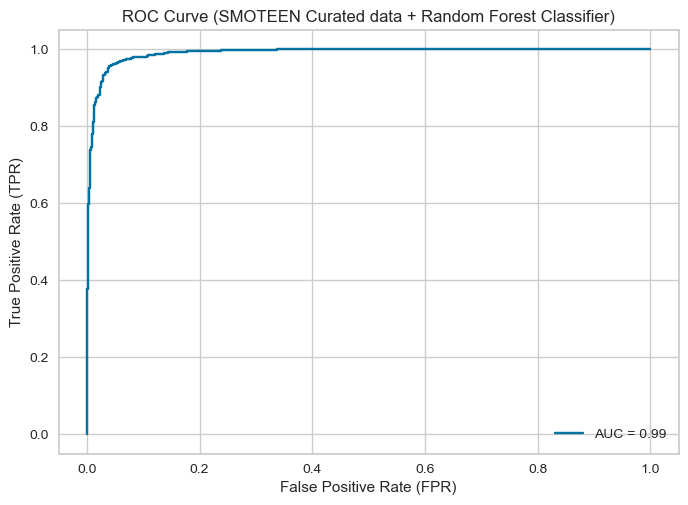

In [26]:
import matplotlib.pyplot as plt

# Obtain predicted probabilities for the positive class (1)
probs_rf_smote = clf_rfs_smote.predict_proba(Xs_test_rf)[:,1]

# Calculate the false positive rate (FPR) and true positive rate (TPR) for various thresholds
fpr, tpr, thresholds = roc_curve(ys_test_rf, probs_rf_smote)

# Calculate the area under the ROC curve (AUC)
auc_rf_smote = roc_auc_score(ys_test_rf, probs_rf_smote)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = %0.2f' % auc_rf_smote)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (SMOTEEN Curated data + Random Forest Classifier)')
plt.legend(loc='lower right')
plt.savefig('ROC Curve SMOTEEN + RF')

plt.show()


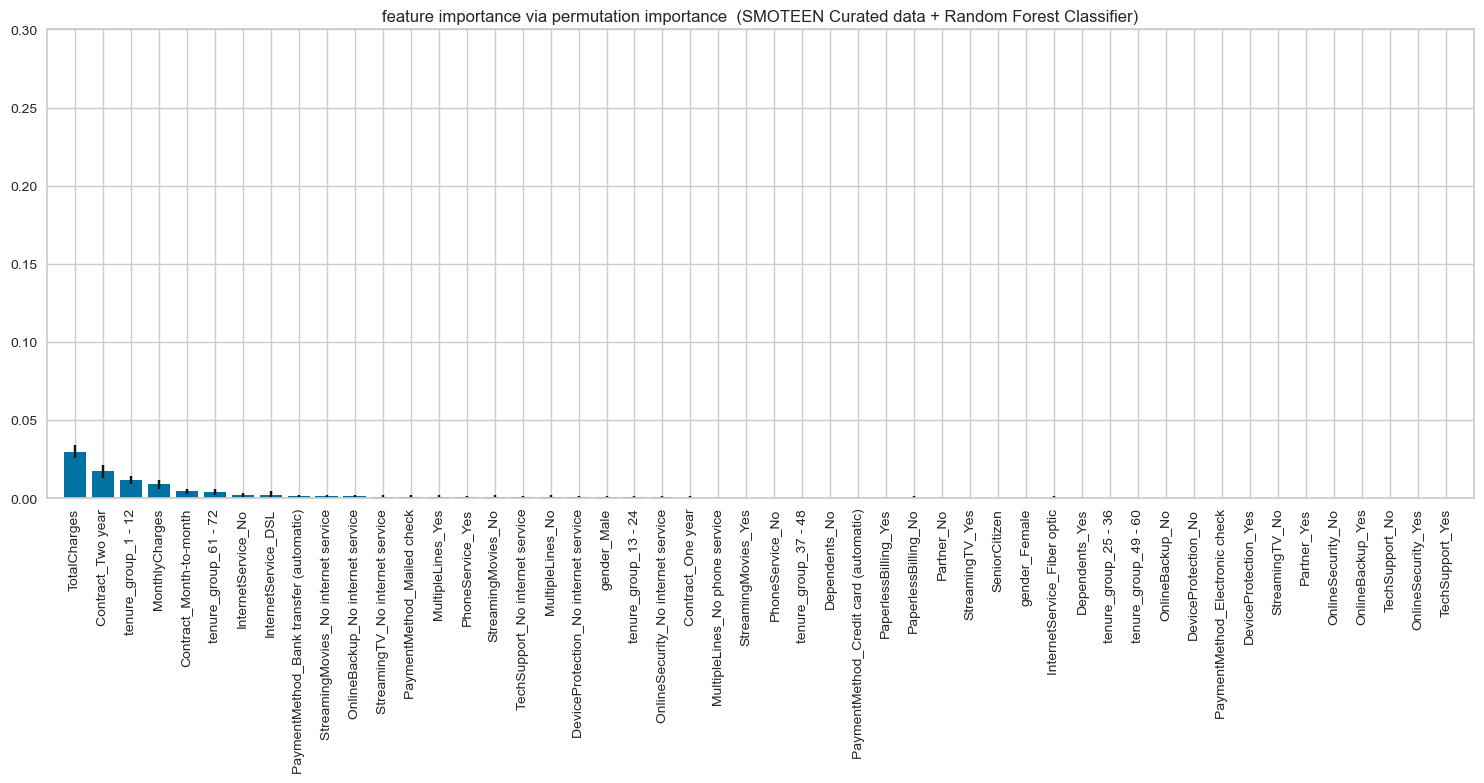

In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=clf_rfs_smote,
    X=Xs_test_rf,
    y=ys_test_rf,
    scoring='recall',
    n_repeats=50,
    random_state=0
)

indices = np.argsort(result['importances_mean'])[::-1]

plt.figure(figsize=(15, 8))
plt.title("feature importance via permutation importance  (SMOTEEN Curated data + Random Forest Classifier)")
plt.bar(
    range(Xs_test_rf.shape[1]),
    result['importances_mean'][indices],
    yerr=result['importances_std'][indices]
)

plt.xticks(range(Xs_test_rf.shape[1]), Xs_test_rf.columns[indices], rotation=90)
plt.xlim([-1, Xs_test_rf.shape[1]])
plt.ylim([0, 0.3])

plt.tight_layout()
plt.savefig('Feature Importance SMOTEEN + Random Forest Classifier.pdf')

plt.show()

we see that Random Forest classifier is giving good results so we'll save this model for using it deployment

## Saving the model

In [31]:
import pickle


In [32]:
filename = 'rf.pkl'
pickle.dump(clf_rfs_smote, open(filename, 'wb'))

In [33]:
load_model = pickle.load(open(filename, 'rb'))


In [34]:
model_score_rf = load_model.score(Xs_test_rf, ys_test_rf)

In [35]:
model_score_rf

0.9549343981745579

Our final model i.e. RF Classifier with SMOTEENN, is now ready and dumped in rf.pkl, which we will use and prepare API's so that we can access our model from UI.